# Outlier Detection with VAEs

In the cell below, you can find the implementation of VAE. For this lab, it is not essential to understand how the model works, but you are, of course, invited to spend some pondering the code. It is based on the implementation described [here](https://hunterheidenreich.com/posts/modern-variational-autoencoder-in-pytorch/) and uses many recent PyTorch features.

If you don't want to wait, you can download a (not so good) checkpoint from [here]() and skip all the training-related cells after the model definition. Make sure to set the variables below accordingly!

In [ ]:
TRAIN_MODEL = True  # Set to False if you don't want to train a new VAE.
CKPT_PATH = None  # Set to path of the checkpoint you downloaded / trained previously)

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

from dataclasses import dataclass

class VAE(nn.Module):
    """
    Variational Autoencoder (VAE) class.
    
    Args:
        input_dim (int): Dimensionality of the input data.
        hidden_dim (int): Dimensionality of the hidden layer.
        latent_dim (int): Dimensionality of the latent space.
    """

    @dataclass
    class VAEOutput:
        """
        Dataclass for VAE output.
        
        Attributes:
            z_dist (torch.distributions.Distribution): The distribution of the latent variable z.
            z_sample (torch.Tensor): The sampled value of the latent variable z.
            x_recon (torch.Tensor): The reconstructed output from the VAE.
            loss (torch.Tensor): The overall loss of the VAE.
            loss_recon (torch.Tensor): The reconstruction loss component of the VAE loss.
            loss_kl (torch.Tensor): The KL divergence component of the VAE loss.
        """
        z_dist: torch.distributions.Distribution
        z_sample: torch.Tensor
        x_recon: torch.Tensor
        
        loss: torch.Tensor
        loss_recon: torch.Tensor
        loss_kl: torch.Tensor

    def __init__(self, input_dim, hidden_dim, latent_dim):
        super(VAE, self).__init__()
                
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.SiLU(),
            nn.Linear(hidden_dim, hidden_dim // 2),
            nn.SiLU(),
            nn.Linear(hidden_dim // 2, hidden_dim // 4),
            nn.SiLU(),
            nn.Linear(hidden_dim // 4, hidden_dim // 8),
            nn.SiLU(), 
            nn.Linear(hidden_dim // 8, 2 * latent_dim), # 2 for mean and variance.
        )
        self.softplus = nn.Softplus()
        
        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, hidden_dim // 8),
            nn.SiLU(),  # Swish activation function
            nn.Linear(hidden_dim // 8, hidden_dim // 4),
            nn.SiLU(),  # Swish activation function
            nn.Linear(hidden_dim // 4, hidden_dim // 2),
            nn.SiLU(),  # Swish activation function
            nn.Linear(hidden_dim // 2, hidden_dim),
            nn.SiLU(),  # Swish activation function
            nn.Linear(hidden_dim, input_dim),
            nn.Sigmoid(),
        )
        
    def encode(self, x, eps: float = 1e-8):
        """
        Encodes the input data into the latent space.
        
        Args:
            x (torch.Tensor): Input data.
            eps (float): Small value to avoid numerical instability.
        
        Returns:
            torch.distributions.MultivariateNormal: Normal distribution of the encoded data.
        """
        x = self.encoder(x)
        mu, logvar = torch.chunk(x, 2, dim=-1)
        scale = self.softplus(logvar) + eps
        scale_tril = torch.diag_embed(scale)
        
        return torch.distributions.MultivariateNormal(mu, scale_tril=scale_tril)
        
    def reparameterize(self, dist):
        """
        Reparameterizes the encoded data to sample from the latent space.
        
        Args:
            dist (torch.distributions.MultivariateNormal): Normal distribution of the encoded data.
        Returns:
            torch.Tensor: Sampled data from the latent space.
        """
        return dist.rsample()
    
    def decode(self, z):
        """
        Decodes the data from the latent space to the original input space.
        
        Args:
            z (torch.Tensor): Data in the latent space.
        
        Returns:
            torch.Tensor: Reconstructed data in the original input space.
        """
        return self.decoder(z)
    
    def forward(self, x, compute_loss: bool = True):
        """
        Performs a forward pass of the VAE.
        
        Args:
            x (torch.Tensor): Input data.
            compute_loss (bool): Whether to compute the loss or not.
        
        Returns:
            VAEOutput: VAE output dataclass.
        """
        dist = self.encode(x)
        z = self.reparameterize(dist)
        recon_x = self.decode(z)
        
        if not compute_loss:
            return VAE.VAEOutput(
                z_dist=dist,
                z_sample=z,
                x_recon=recon_x,
                loss=None,
                loss_recon=None,
                loss_kl=None,
            )
        
        # compute loss terms 
        loss_recon = F.binary_cross_entropy(recon_x, x + 0.5, reduction='none').sum(-1).mean()
        std_normal = torch.distributions.MultivariateNormal(
            torch.zeros_like(z, device=z.device),
            scale_tril=torch.eye(z.shape[-1], device=z.device).unsqueeze(0).expand(z.shape[0], -1, -1),
        )
        loss_kl = torch.distributions.kl.kl_divergence(dist, std_normal).mean()
                
        loss = loss_recon + loss_kl
        
        return VAE.VAEOutput(
            z_dist=dist,
            z_sample=z,
            x_recon=recon_x,
            loss=loss,
            loss_recon=loss_recon,
            loss_kl=loss_kl,
        )

The next cell just prepares the data. Nothing you haven't seen before, but make sure to execute it, even if you don't want to train the model. We need the data later!

In [ ]:
import torch
from torchvision import datasets
from torchvision.transforms import v2


batch_size = 128
transform = v2.Compose([
    v2.ToImage(), 
    v2.ToDtype(torch.float32, scale=True),
    v2.Lambda(lambda x: x.view(-1) - 0.5),
])

# Download and load the training data
train_data = datasets.MNIST(
    '~/.pytorch/MNIST_data/', 
    download=True, 
    train=True, 
    transform=transform,
)
# Download and load the test data
test_data = datasets.MNIST(
    '~/.pytorch/MNIST_data/', 
    download=True, 
    train=False, 
    transform=transform,
)

# Create data loaders
train_loader = torch.utils.data.DataLoader(
    train_data, 
    batch_size=batch_size, 
    shuffle=True,
)
test_loader = torch.utils.data.DataLoader(
    test_data, 
    batch_size=batch_size, 
    shuffle=False,
)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = VAE(input_dim=784, hidden_dim=512, latent_dim=16).to(device)
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-3, weight_decay=1e-2)

The next three cells define training loop.

In [ ]:
from tqdm import tqdm

def train(model, dataloader, optimizer, prev_updates):
    """
    Trains the model on the given data.
    
    Args:
        model (nn.Module): The model to train.
        dataloader (torch.utils.data.DataLoader): The data loader.
        loss_fn: The loss function.
        optimizer: The optimizer.
    """
    model.train()  # Set the model to training mode
    
    for batch_idx, (data, target) in enumerate(tqdm(dataloader)):
        n_upd = prev_updates + batch_idx
        
        data = data.view(data.size(0), -1)  # Flatten the data
        data = data.to(device)
        
        optimizer.zero_grad()  # Zero the gradients
        
        output = model(data)  # Forward pass
        loss = output.loss
        
        loss.backward()
        
        if n_upd % 100 == 0:
            # Calculate and log gradient norms
            total_norm = 0.0
            for p in model.parameters():
                if p.grad is not None:
                    param_norm = p.grad.data.norm(2)
                    total_norm += param_norm.item() ** 2
            total_norm = total_norm ** (1. / 2)
        
            print(f'Step {n_upd:,} (N samples: {n_upd*batch_size:,}), Loss: {loss.item():.4f} (Recon: {output.loss_recon.item():.4f}, KL: {output.loss_kl.item():.4f}) Grad: {total_norm:.4f}')
            
        # gradient clipping
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)    
        
        optimizer.step()  # Update the model parameters
        
    return prev_updates + len(dataloader)

In [ ]:
def test(model, dataloader):
    """
    Tests the model on the given data.
    
    Args:
        model (nn.Module): The model to test.
        dataloader (torch.utils.data.DataLoader): The data loader.
        cur_step (int): The current step.
    """
    model.eval()  # Set the model to evaluation mode
    test_loss = 0
    test_recon_loss = 0
    test_kl_loss = 0
    
    with torch.no_grad():
        for data, target in tqdm(dataloader, desc='Testing'):
            data = data.to(device)
            data = data.view(data.size(0), -1)  # Flatten the data
            
            output = model(data, compute_loss=True)  # Forward pass
            
            test_loss += output.loss.item()
            test_recon_loss += output.loss_recon.item()
            test_kl_loss += output.loss_kl.item()
            
    test_loss /= len(dataloader)
    test_recon_loss /= len(dataloader)
    test_kl_loss /= len(dataloader)
    print(f'====> Test set loss: {test_loss:.4f} (BCE: {test_recon_loss:.4f}, KLD: {test_kl_loss:.4f})')

Make sure you set the `TRAIN_MODEL` and `CKPT_PATH` variables correctly, depending on whether you want to train a new model or not, then execute the next cell.

In [ ]:
num_epochs = 20
prev_updates = 0
if TRAIN_MODEL:
    for epoch in range(num_epochs):
        print(f'Epoch {epoch+1}/{num_epochs}')
        prev_updates = train(model, train_loader, optimizer, prev_updates)
        test(model, test_loader)
else:
    model.load_state_dict(torch.load())

model.eval()

In [ ]:
torch.save(model.state_dict(), 'outlier_vae.pth')

To validate that our model works, let's quickly validate the reconstructions by visual inspection.

In [ ]:
import matplotlib.pyplot as plt

# Set the model to evaluation mode
model.eval()

# Select a random batch of images from the test dataset
data, _ = next(iter(test_loader))
data = data.to(device)

# Generate reconstructions
with torch.no_grad():
    output = model(data, compute_loss=False)
    reconstructions = output.x_recon.cpu().numpy()

# Plot the original images and their reconstructions
fig, axes = plt.subplots(nrows=2, ncols=10, figsize=(20, 4))

for i in range(10):
    # Plot original image
    axes[0, i].imshow(data[i].view(28, 28), cmap='gray')
    axes[0, i].axis('off')
    
    # Plot reconstructed image
    axes[1, i].imshow(reconstructions[i].reshape(28, 28), cmap='gray')
    axes[1, i].axis('off')

plt.tight_layout()
plt.show()

Now, let's shift our attention to the topic for which we are actually here: Detecting outliers.
As mentioned in the introduction, we are trying to detect outliers by checking how well the input data can be reconstructed.
For this, we have to set a threshold, above which we declare a sample an _outlier_. We will take care of this later, for now, just assume we have it already. Finish the implementation of the function in the next section.

In [ ]:
def detect_outlier(vae, x, th):
    """
    vae: The variational autoencoder.
    x: The sample we want to compare against training the distribution.
    th: The detection threshold.
    """
    # Compute reconstruction loss for x.
    output = vae(x, compute_loss=True)

    # Compare loss against threshold.
    if output.loss.item() > th:
        return True
    return False

We've procrastinated for long enough. Let's find the threshold. Here is our approach:

1. Compute the reconstruction loss for (a subset of) the training samples.
2. Assume that x% of the data are outliers.
3. Set the threshold to the x-th percentile.

As you can see, this is not exact science. In reality, the setting of such thresholds is a long process of calibration until you have found a value that is suitable for your use case. As is often the case in statistics, it comes down to balancing 

Here, let's assume that 1% of all samples are outliers.

In [ ]:
# TODO: Find the threshold!
threshold = 0.0
losses = []
with torch.no_grad():
    for data, target in tqdm(train_loader, desc='Computing threshold'):
        data = data.to(device)
        data = data.view(data.size(0), -1)  # Flatten the data

        output = model(data, compute_loss=True)  # Forward pass
        
        # TODO: Compute the reconstruction loss.
        loss = output.loss_recon.item()
        losses.append(loss)

# Select the 99th percentile of the loss as the threshold
losses = torch.tensor(losses)
threshold = torch.quantile(losses, 0.99).item()

Great. Now we have everything to detect outliers. To test our model, let's create some distorted samples!
For this we'll use alibi-detect, a library that provides a lot of tools for outlier detection and similar tasks. (Yes, we could have used it for the VAE as well, but where's the fun in that?)
You can customize the distortion by changing the parameters in the call to [`apply_mask`](https://docs.seldon.io/projects/alibi-detect/en/latest/api/alibi_detect.utils.perturbation.html#alibi_detect.utils.perturbation.apply_mask).

In [76]:
import numpy as np
from alibi_detect.utils.perturbation import apply_mask

np.random.seed(0)

# Index of the sample we want to perturb.
i = 0

# create masked instance
x = test_data[i][0].reshape(1, 28, 28, 1)
x_perturbed, _ = torch.tensor(apply_mask(
    x,
    mask_size=(8, 8),
    n_masks=1,
    channels=[0],
    mask_type="normal",
    noise_distr=(0, 0.5),
    clip_rng=(0, 1),
)).to(torch.float32)

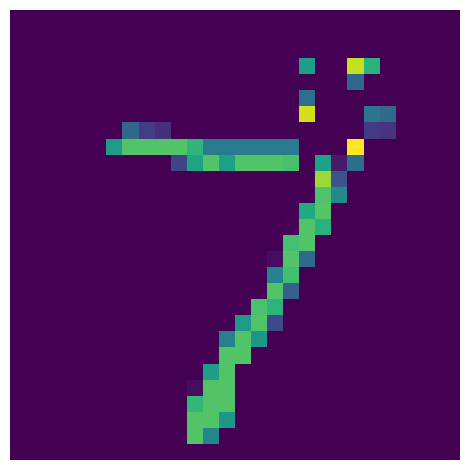

In [77]:
import matplotlib.pyplot as plt

plt.imshow(x_perturbed.reshape(28, 28))
plt.axis('off')

plt.tight_layout()
plt.show()

With these samples, let's test the `detect_outliers` function.

In [78]:
detect_outlier(model, x_perturbed.flatten(), threshold)

RuntimeError: all elements of target should be between 0 and 1